In [4]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [6]:
all_files = glob.glob('W5E5_temp_calib/RGI62/b_080/L3/summary/glacier_statistics_*.csv')

li = []
for filename in all_files:
    df = pd.read_csv(filename, low_memory=False)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df = df.set_index('rgi_id').sort_index()

In [7]:
assert len(df) == 215547

In [8]:
dis = ((df.cenlon - df.baseline_climate_ref_pix_lon)**2 + (df.cenlat - df.baseline_climate_ref_pix_lat)**2)**0.5

In [9]:
dis.loc[dis > (0.25**2 + 0.25**2)**0.5]

Series([], dtype: float64)

In [10]:
df['reference_mb_err'].isnull().sum()

1428

In [11]:
df['reference_mb'].isnull().sum()

1426

In [12]:
df['melt_f'].isnull().sum()

1426

In [13]:
df.loc[~df['melt_f'].isnull() & df['reference_mb_err'].isnull()][['reference_mb', 'reference_mb_err']]

reference_mb  reference_mb_err
rgi_id                                        
RGI60-17.03044           0.0               NaN
RGI60-17.03053           0.0               NaN

In [14]:
df.loc[df['melt_f'].isnull()].rgi_area_km2.sum() / df.rgi_area_km2.sum(), df.rgi_area_km2.sum()

(0.0010177632406523575, 705738.7919999999)

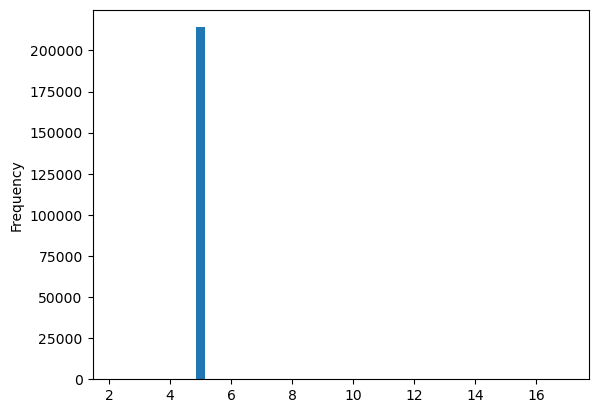

In [15]:
df['melt_f'].plot.hist(bins=50);

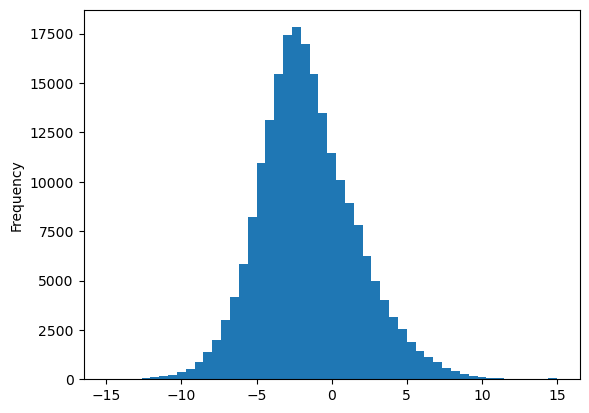

In [16]:
df['temp_bias'].plot.hist(bins=51);

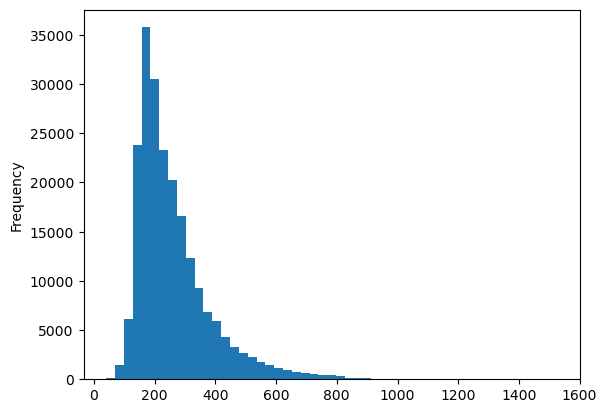

In [17]:
df['reference_mb_err'].plot.hist(bins=51);

In [18]:
df['reference_mb_err'].min()

40.3

In [19]:
df['reference_mb_err'].quantile([0.5, 0.9, 0.95])

0.50    225.7
0.90    421.1
0.95    515.6
Name: reference_mb_err, dtype: float64

##  On dataset

In [20]:
# Sanitize
odf = df.loc[~ df['temp_bias'].isnull()].copy()

In [21]:
odf.loc[odf['reference_mb_err'].isnull(), 'reference_mb_err'] = df['reference_mb_err'].quantile(0.9)

In [22]:
odf['reference_mb_err_weights'] = 1 / odf['reference_mb_err']

In [23]:
with xr.open_dataset('/home/www/oggm/climate/gswp3-w5e5/unflattened/monthly/gswp3-w5e5_obsclim_tas_global_monthly_1901_2019.nc') as dse:
    # dse = dse.resample(time='AS').mean(dim='time')
    dse = dse.isel(time=-1)

In [24]:
nx, ny = dse.dims['lon'], dse.dims['lat']
lon_bins = np.linspace(dse.lon.data[0] - 0.25, dse.lon.data[-1] + 0.25, nx+1)
lat_bins = np.linspace(dse.lat.data[0] + 0.25, dse.lat.data[-1] - 0.25, ny+1)

In [25]:
# Nearest neighbor lookup
odf['lon_id'] = np.digitize(odf['cenlon'], lon_bins)-1
odf['lat_id'] = np.digitize(odf['cenlat'], lat_bins)-1
odf['lon_val'] = dse.lon.data[odf.lon_id]
odf['lat_val'] = dse.lat.data[odf.lat_id]

In [26]:
odf['ll_dist_to_point'] = ((dse.lon.data[odf.lon_id] - odf.cenlon)**2 + (dse.lat.data[odf.lat_id] - odf.cenlat)**2)**0.5

In [27]:
assert odf['ll_dist_to_point'].max() < (0.25**2 + 0.25**2)**0.5
# odf['dist_to_point'].plot.hist(bins=100);

In [28]:
# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id')[['unique_id', 'lon_id', 'lat_id', 'lon_val', 'lat_val']].set_index('unique_id')
mdf['rgi_area_km2'] = odf.groupby('unique_id')['rgi_area_km2'].sum()
print('Total number of valid glaciers: {} and number of W5E5 gridpoints with valid glaciers in them: {}'.format(len(odf), len(mdf)))

Total number of valid glaciers: 214121 and number of W5E5 gridpoints with valid glaciers in them: 4633


In [29]:
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['rgi_area_km2']
dse['glacier_mask'] = (('lat', 'lon'), np.isfinite(mask))
dse['glacier_area'] = (('lat', 'lon'), mask)
dse['weight_glacier'] = (('lat', 'lon'), mask / np.nansum(mask))

In [30]:
import cartopy.crs as ccrs
import seaborn as sns

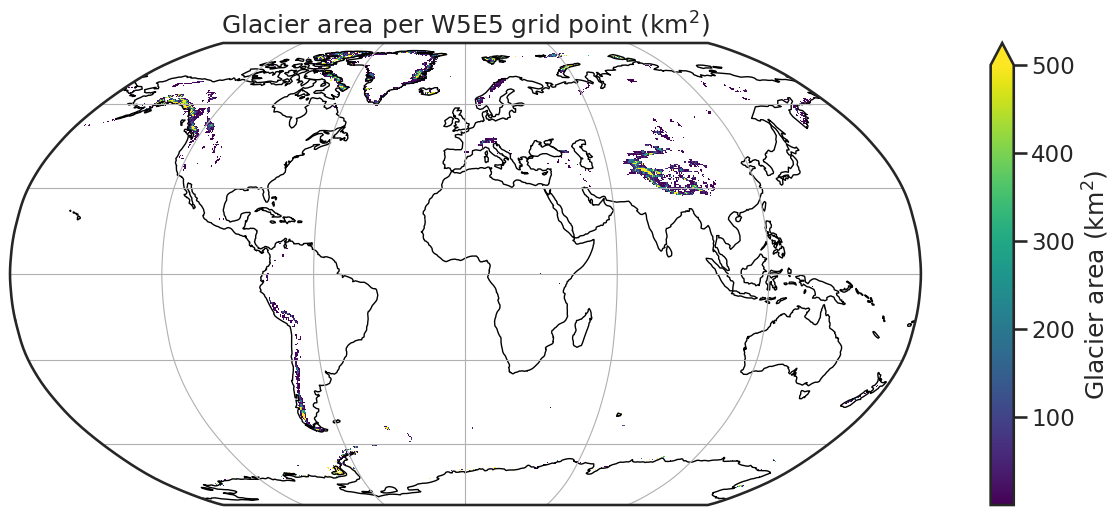

In [31]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    dse['glacier_area'].plot.imshow(ax=ax, transform=ccrs.PlateCarree(), vmax=500, 
                                    cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Glacier area per W5E5 grid point (km$^{2}$)');

In [32]:
mdf['n_glaciers'] = odf.groupby('unique_id')['temp_bias'].count()

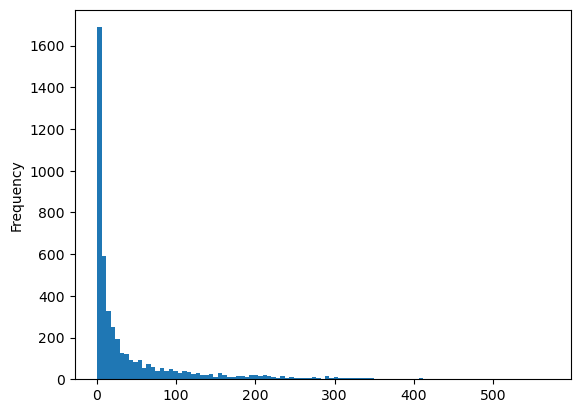

In [33]:
mdf['n_glaciers'].plot.hist(bins=101);

In [34]:
def quantile_1D(data, weights, quantile):
    """
    Compute the weighted quantile of a 1D numpy array.
    Parameters
    ----------
    data : ndarray
        Input array (one dimension).
    weights : ndarray
        Array with the weights of the same size of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.
    Returns
    -------
    quantile_1D : float
        The output value.
    """
    # Check the data
    if not isinstance(data, np.matrix):
        data = np.asarray(data)
    if not isinstance(weights, np.matrix):
        weights = np.asarray(weights)
    nd = data.ndim
    if nd != 1:
        raise TypeError("data must be a one dimensional array")
    ndw = weights.ndim
    if ndw != 1:
        raise TypeError("weights must be a one dimensional array")
    if data.shape != weights.shape:
        raise TypeError("the length of data and weights must be the same")
    if ((quantile > 1.) or (quantile < 0.)):
        raise ValueError("quantile must have a value between 0. and 1.")
    # Sort the data
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    # Compute the auxiliary arrays
    Sn = np.cumsum(sorted_weights)
    # TODO: Check that the weights do not sum zero
    #assert Sn != 0, "The sum of the weights must not be zero"
    Pn = (Sn-0.5*sorted_weights)/Sn[-1]
    # Get the value of the weighted median
    return np.interp(quantile, Pn, sorted_data)

In [35]:
mdf['median_temp_bias'] = odf.groupby('unique_id')['temp_bias'].median()

In [36]:
def weighted_median_area(df):
    return quantile_1D(df.temp_bias.values, df.rgi_area_km2.values, 0.5)
mdf['median_temp_bias_w_area'] = odf.groupby('unique_id')[['temp_bias', 'rgi_area_km2']].apply(weighted_median_area)

def weighted_median_err(df):
    return quantile_1D(df.temp_bias.values, df.reference_mb_err_weights.values, 0.5)
mdf['median_temp_bias_w_err'] = odf.groupby('unique_id')[['temp_bias', 'reference_mb_err_weights']].apply(weighted_median_err)

In [37]:
min_glaciers = 12
max_radius = 11
for i, s in mdf.iterrows():
    if s.n_glaciers >= min_glaciers:
        mdf.loc[i, 'n_glaciers_grouped'] = mdf.loc[i, 'n_glaciers']
        mdf.loc[i, 'search_radius'] = 0
        mdf.loc[i, 'median_temp_bias_grouped'] = mdf.loc[i, 'median_temp_bias']
        mdf.loc[i, 'median_temp_bias_w_area_grouped'] = mdf.loc[i, 'median_temp_bias_w_area']
        mdf.loc[i, 'median_temp_bias_w_err_grouped'] = mdf.loc[i, 'median_temp_bias_w_err']
        continue
    radius = 1
    while radius < max_radius:
        sel = odf.loc[((np.abs(odf.lon_id - s.lon_id) <= radius) | (np.abs(odf.lon_id - s.lon_id) >= 719 + radius)) & (np.abs(odf.lat_id - s.lat_id) <= radius)]
        mdf.loc[i, 'n_glaciers_grouped'] = len(sel)
        mdf.loc[i, 'search_radius'] = radius
        mdf.loc[i, 'median_temp_bias_grouped'] = sel['temp_bias'].median()
        mdf.loc[i, 'median_temp_bias_w_area_grouped'] = weighted_median_area(sel)
        mdf.loc[i, 'median_temp_bias_w_err_grouped'] = weighted_median_err(sel)
        if len(sel) >= min_glaciers:
            break
        radius += 1
mdf['n_glaciers_grouped'] = mdf['n_glaciers_grouped'].astype(int)
mdf['search_radius'] = mdf['search_radius'].astype(int)

In [38]:
mdf['search_radius'].value_counts().sort_index()

0     2446
1     1779
2      173
3       68
4       28
5       20
6       18
7       13
8       13
9        5
10      70
Name: search_radius, dtype: int64

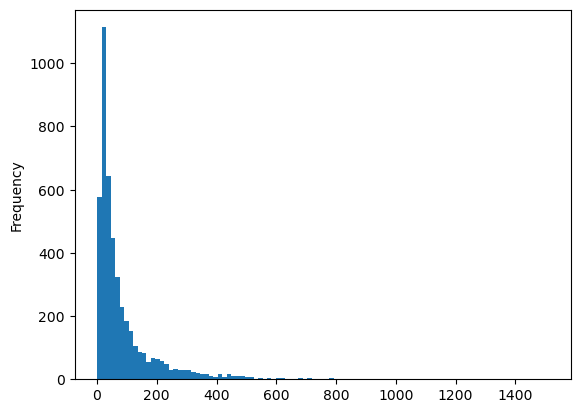

In [39]:
mdf['n_glaciers_grouped'].plot.hist(bins=101);

In [40]:
mdf['n_glaciers_grouped'].mode()

0    14
Name: n_glaciers_grouped, dtype: int64

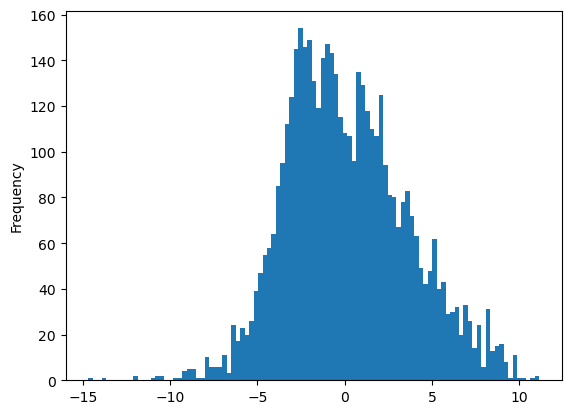

In [41]:
mdf['median_temp_bias_grouped'].plot.hist(bins=101);

In [42]:
mdf['median_temp_bias_grouped'].quantile([0, 0.05, 0.5, 0.95, 1])

0.00   -14.683393
0.05    -4.864962
0.50    -0.253813
0.95     6.467922
1.00    11.156750
Name: median_temp_bias_grouped, dtype: float64

In [43]:
mdf['median_temp_bias_w_area_grouped'].quantile([0, 0.05, 0.5, 0.95, 1])

0.00   -14.634761
0.05    -4.727146
0.50     0.061150
0.95     6.790239
1.00    11.464324
Name: median_temp_bias_w_area_grouped, dtype: float64

In [44]:
mdf['median_temp_bias_w_err_grouped'].quantile([0, 0.05, 0.5, 0.95, 1])

0.00   -14.260712
0.05    -4.826452
0.50    -0.201686
0.95     6.549637
1.00    11.227498
Name: median_temp_bias_w_err_grouped, dtype: float64

In [45]:
mdf

lon_id  lat_id  lon_val  lat_val  rgi_area_km2  n_glaciers  \
unique_id                                                               
066_052        66      52  -146.75    63.75       100.826          78   
066_053        66      53  -146.75    63.25       596.561          64   
067_053        67      53  -146.25    63.25        92.814          61   
065_052        65      52  -147.25    63.75       418.454          75   
067_052        67      52  -146.25    63.75       195.022          65   
...           ...     ...      ...      ...           ...         ...   
284_288       284     288   -37.75   -54.25       113.081          78   
285_287       285     287   -37.25   -53.75         0.030           1   
284_287       284     287   -37.75   -53.75         2.087           6   
288_289       288     289   -35.75   -54.75        56.066          61   
435_273       435     273    37.75   -46.75         0.528           1   

           median_temp_bias  median_temp_bias_w_area  median_temp_bias_w_err  \
unique_id                                                                      
066_052            1.656244                -2.339046                1.256722   
066_053           -1.666875                -1.554139               -1.644006   
067_053           -1.330019                -1.595847               -1.378412   
065_052           -1.193442                -3.018468               -1.465574   
067_052            1.192603                -1.825687                0.452715   
...                     ...                      ...                     ...   
284_288            1.301259                 1.334896                1.401481   
285_287            1.007318                 1.007318                1.007318   
284_287            1.040875                 1.050751                1.040303   
288_289            2.885223                 3.398847                2.915881   
435_273            1.181879                 1.181879                1.181879   

           n_glaciers_grouped  search_radius  median_temp_bias_grouped  \
unique_id                                                                
066_052                    78              0                  1.656244   
066_053                    64              0                 -1.666875   
067_053                    61              0                 -1.330019   
065_052                    75              0                 -1.193442   
067_052                    65              0                  1.192603   
...                       ...            ...                       ...   
284_288                    78              0                  1.301259   
285_287                   274              1                  1.224633   
284_287                   189              1                  1.431748   
288_289                    61              0                  2.885223   
435_273                     1             10                  1.181879   

           median_temp_bias_w_area_grouped  median_temp_bias_w_err_grouped  
unique_id                                                                   
066_052                          -2.339046                        1.256722  
066_053                          -1.554139                       -1.644006  
067_053                          -1.595847                       -1.378412  
065_052                          -3.018468                       -1.465574  
067_052                          -1.825687                        0.452715  
...                                    ...                             ...  
284_288                           1.334896                        1.401481  
285_287                           1.866003                        1.222485  
284_287                           1.913667                        1.498767  
288_289                           3.398847                        2.915881  
435_273                           1.181879                        1.181879  

[4633 rows x 14 columns]

In [46]:
mdf['median_temp_bias_w_err_grouped'].isnull().sum()

0

In [47]:
mdf.to_csv('/home/users/fmaussion/www_oggm/test_files/w5e5_temp_bias_v2023.4.csv')

In [48]:
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['median_temp_bias_w_err_grouped']
dse['median_temp_bias_w_err_grouped'] = (('lat', 'lon'), mask)

In [49]:
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['median_temp_bias_grouped']
dse['median_temp_bias_grouped'] = (('lat', 'lon'), mask)

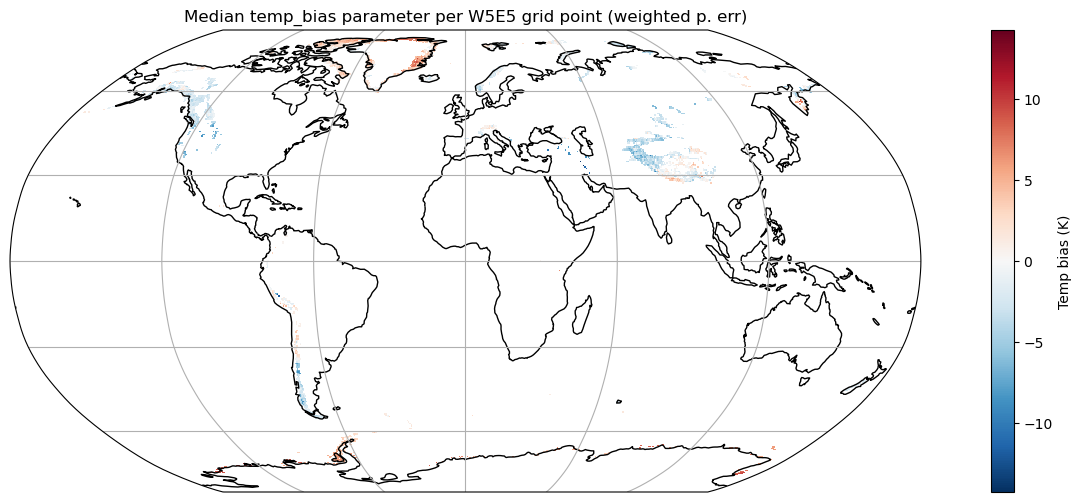

In [50]:
f = plt.figure(figsize=(18, 6))
ax = plt.axes(projection=ccrs.Robinson())
dse['median_temp_bias_w_err_grouped'].plot(ax=ax, transform=ccrs.PlateCarree(), # levels=[-10, -5, -2, 0, 2, 5, 10], cmap='RdBu_r',
                                           cbar_kwargs={'label':'Temp bias (K)'}) 
ax.coastlines(); ax.gridlines(); ax.set_title('Median temp_bias parameter per W5E5 grid point (weighted p. err)');
plt.savefig('median_werr_grouped.png', dpi=300, bbox_inches='tight')

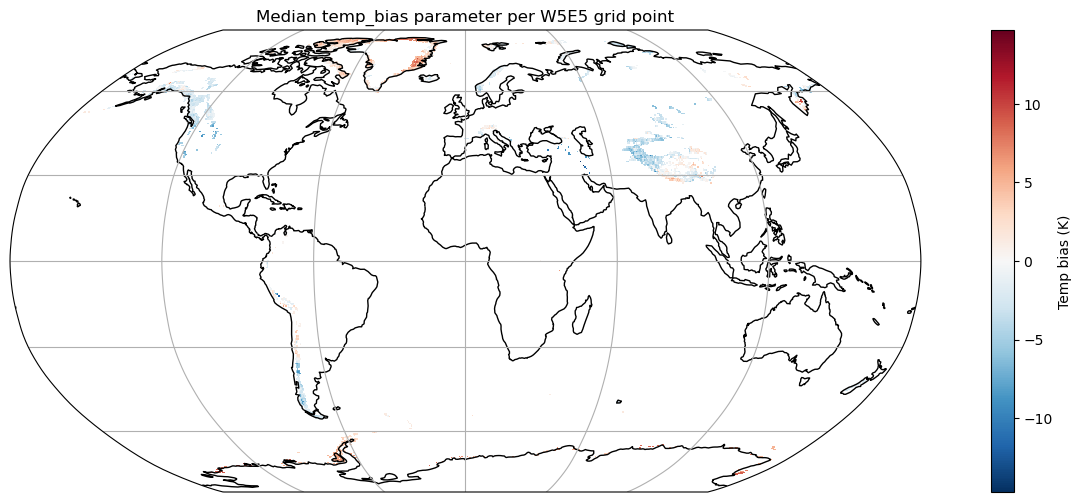

In [51]:
f = plt.figure(figsize=(18, 6))
ax = plt.axes(projection=ccrs.Robinson())
dse['median_temp_bias_grouped'].plot(ax=ax, transform=ccrs.PlateCarree(),
                                           cbar_kwargs={'label':'Temp bias (K)'}) 
ax.coastlines(); ax.gridlines(); ax.set_title('Median temp_bias parameter per W5E5 grid point');
plt.savefig('median_grouped.png', dpi=300, bbox_inches='tight')

In [52]:
def weighted_median_err(df):
    err = 1 / df['reference_mb_err'].values
    return quantile_1D(df.temp_bias.values, err, 0.5)

In [53]:
mdf['median_bias_w_err'] = odf.groupby('unique_id')[['temp_bias', 'reference_mb_err']].apply(weighted_median_err)

mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['median_bias_w_err']
dse['median_bias_w_err'] = (('lat', 'lon'), mask)

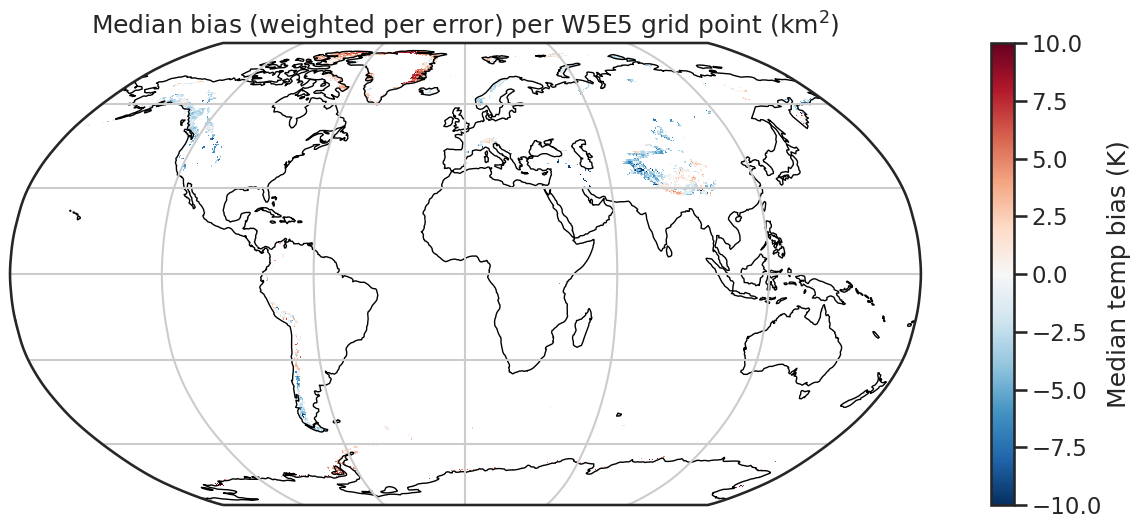

In [217]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    dse['median_bias_w_err'].plot.imshow(ax=ax, transform=ccrs.PlateCarree(), 
                                    cbar_kwargs={'label':'Median temp bias (K)'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Median bias (weighted per error) per W5E5 grid point (km$^{2}$)');
    plt.savefig('median_err.pdf')